In [61]:
import numpy as np
import os
import glob
import pickle
import pandas as pd
from skimage import io, color, filters, measure
from skimage.morphology import closing, disk
from skimage.color import label2rgb
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
from sklearn.exceptions import DataConversionWarning

In [63]:
# Load the trained LDA model
with open('lda_model_9_features.pkl', 'rb') as f:
    lda = pickle.load(f)


print(f'Classes: {lda.classes_}')
print(f'Class Priors: {lda.priors_}')
print(f'Coefficients: {lda.coef_}')
print(f'Number of Features: {lda.n_features_in_}')

Classes: [0 1]
Class Priors: [0.98392283 0.01607717]
Coefficients: [[-1.28168732e-04  2.66862816e-03 -1.63176550e-03  5.05238540e-02
   2.25238120e+01  5.26186805e+01 -1.03441967e+02  1.97686010e+01
  -9.30977054e+01]]
Number of Features: 9


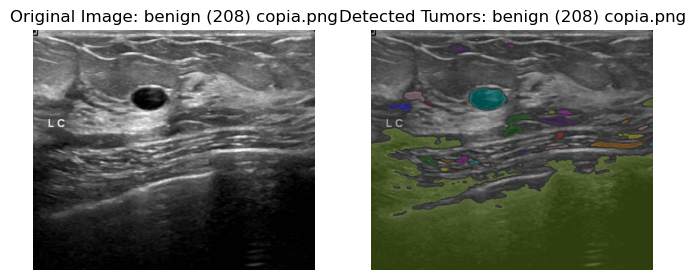

Image Name: benign (208) copia.png
Number of detected tumor regions: 0


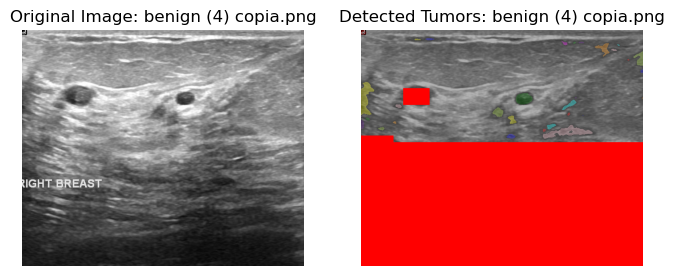

Image Name: benign (4) copia.png
Number of detected tumor regions: 3


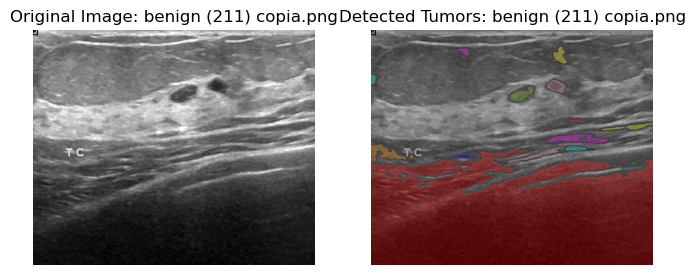

Image Name: benign (211) copia.png
Number of detected tumor regions: 0


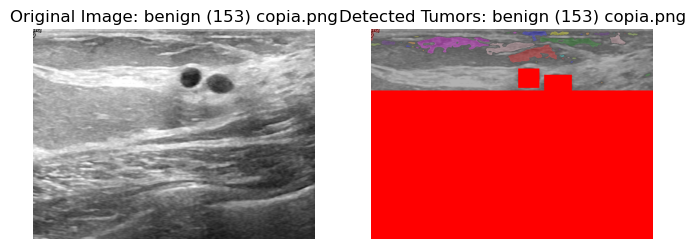

Image Name: benign (153) copia.png
Number of detected tumor regions: 3


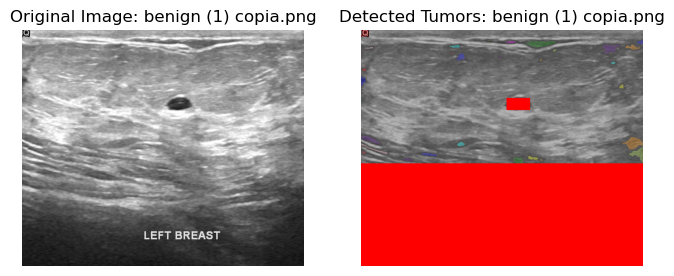

Image Name: benign (1) copia.png
Number of detected tumor regions: 2


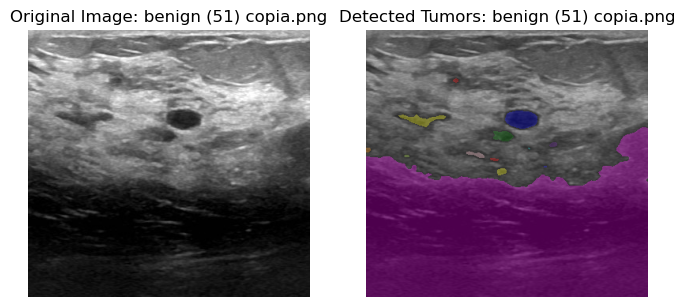

Image Name: benign (51) copia.png
Number of detected tumor regions: 0


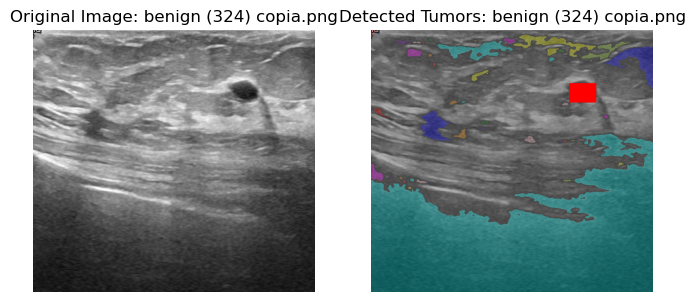

Image Name: benign (324) copia.png
Number of detected tumor regions: 1


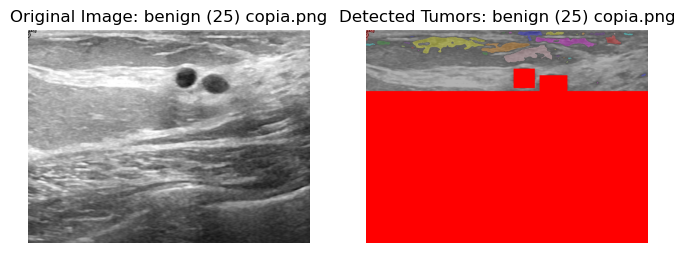

Image Name: benign (25) copia.png
Number of detected tumor regions: 3


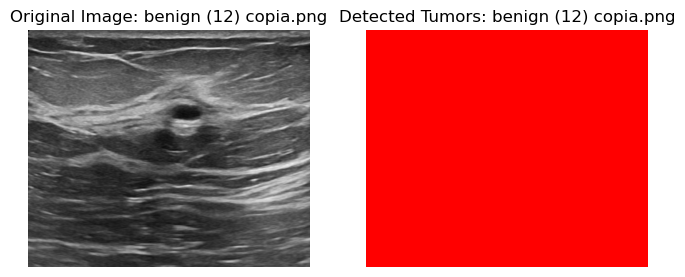

Image Name: benign (12) copia.png
Number of detected tumor regions: 3


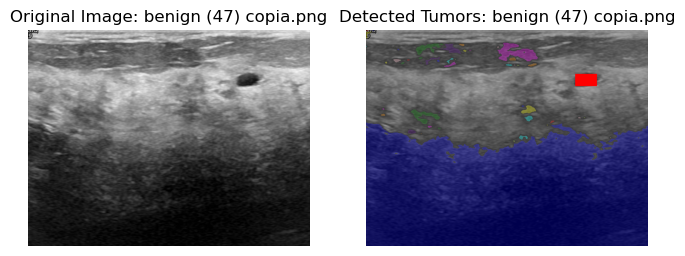

Image Name: benign (47) copia.png
Number of detected tumor regions: 1


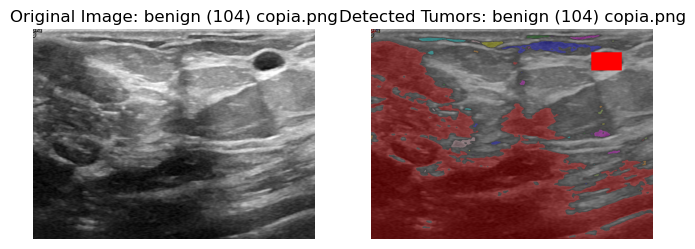

Image Name: benign (104) copia.png
Number of detected tumor regions: 1


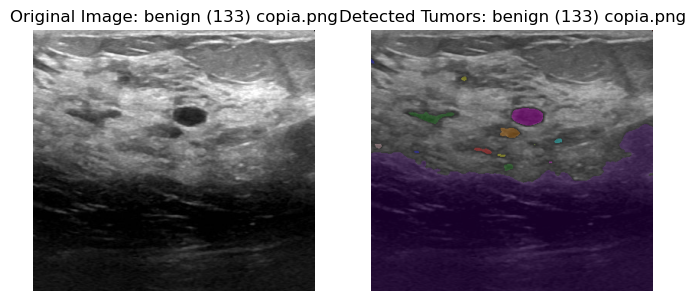

Image Name: benign (133) copia.png
Number of detected tumor regions: 0


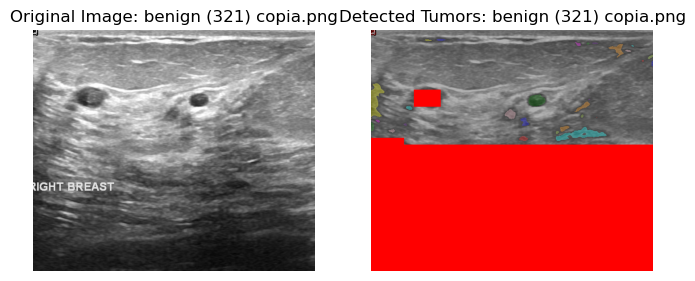

Image Name: benign (321) copia.png
Number of detected tumor regions: 3


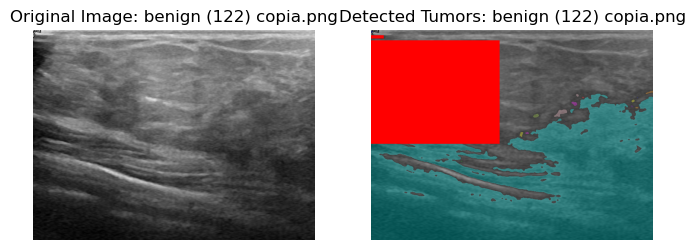

Image Name: benign (122) copia.png
Number of detected tumor regions: 2


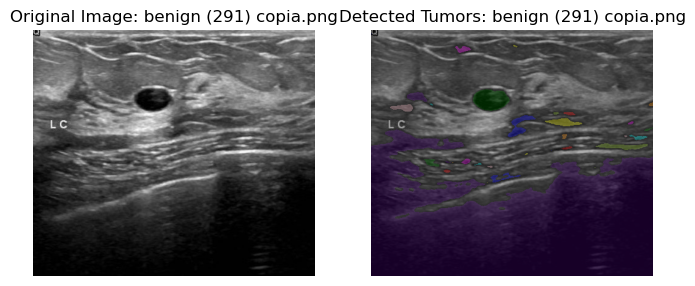

Image Name: benign (291) copia.png
Number of detected tumor regions: 0


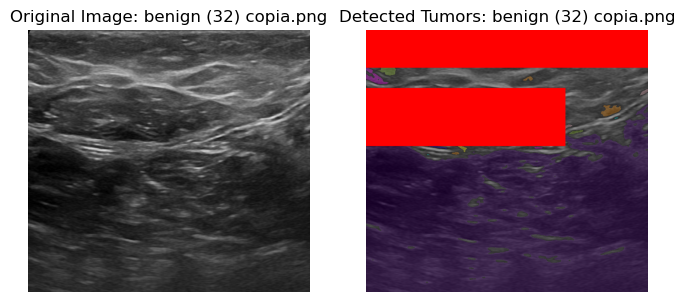

Image Name: benign (32) copia.png
Number of detected tumor regions: 2


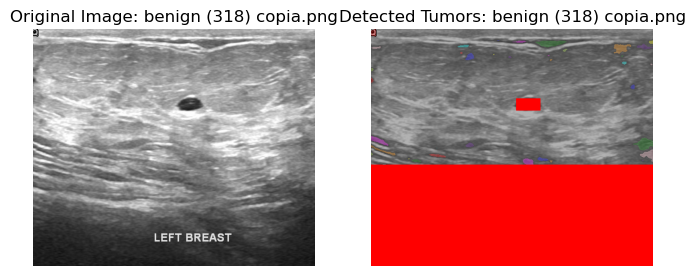

Image Name: benign (318) copia.png
Number of detected tumor regions: 2


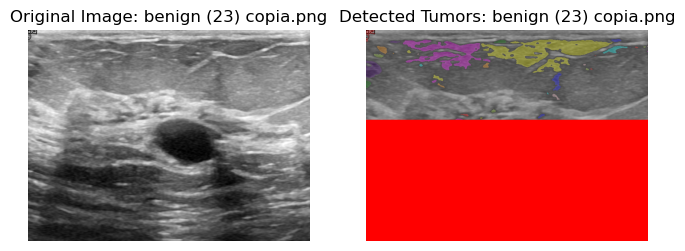

Image Name: benign (23) copia.png
Number of detected tumor regions: 1


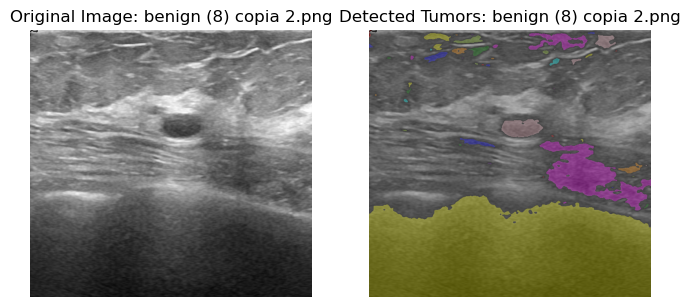

Image Name: benign (8) copia 2.png
Number of detected tumor regions: 0


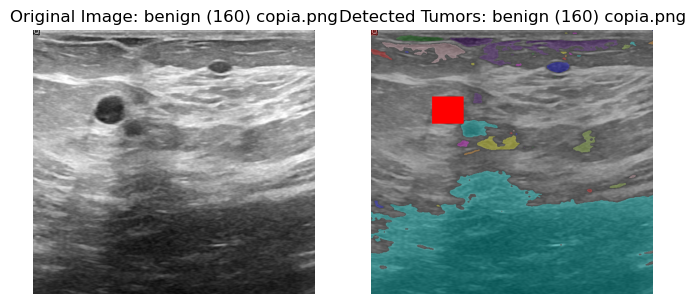

Image Name: benign (160) copia.png
Number of detected tumor regions: 1


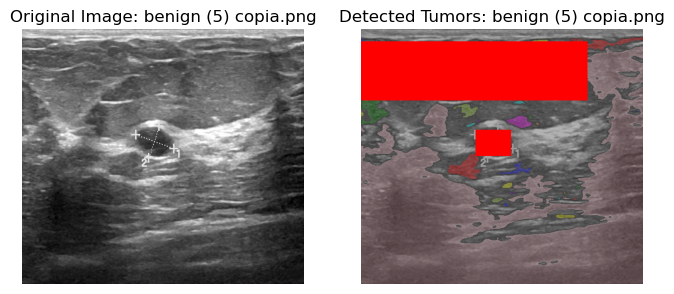

Image Name: benign (5) copia.png
Number of detected tumor regions: 2


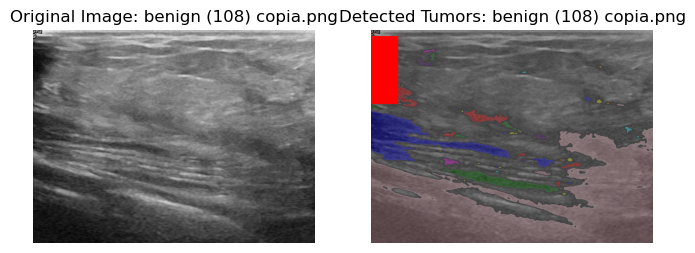

Image Name: benign (108) copia.png
Number of detected tumor regions: 1


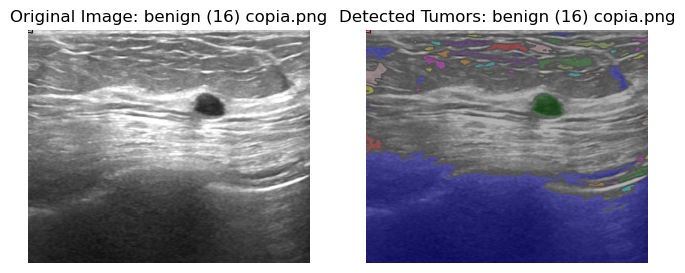

Image Name: benign (16) copia.png
Number of detected tumor regions: 0


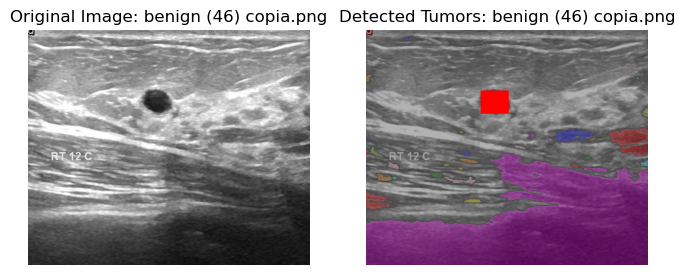

Image Name: benign (46) copia.png
Number of detected tumor regions: 1


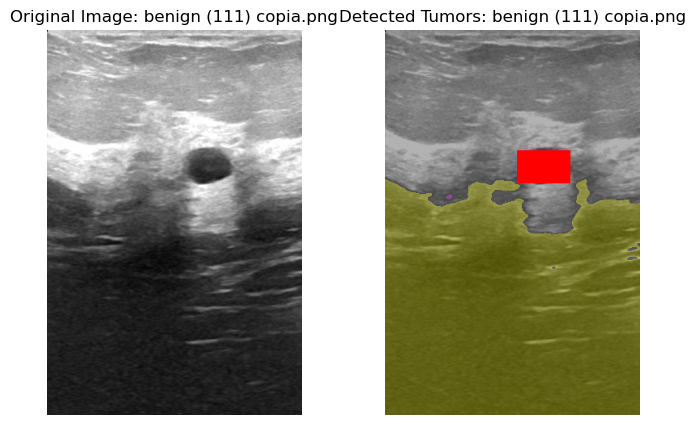

Image Name: benign (111) copia.png
Number of detected tumor regions: 1


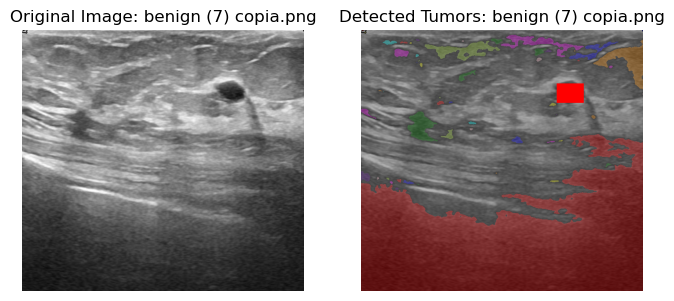

Image Name: benign (7) copia.png
Number of detected tumor regions: 1
Tumor data saved to detected_tumors_with_classifier.csv


In [65]:

tumors_folder = '/Users/mariavivasarias/Desktop/TDI_TUMORS/'
lda_model_path = '/Users/mariavivasarias/Desktop/lda_model_9_features.pkl'

# Load the LDA model
with open(lda_model_path, 'rb') as f:
    lda = pickle.load(f)
    
tumor_images = glob.glob(os.path.join(tumors_folder, '*.png'))
tumor_data=[]
# Process each image
for image_path in tumor_images:
    image_name = os.path.basename(image_path)  

    # Read and preprocess 
    image = io.imread(image_path)
    gray_image = color.rgb2gray(image)
    blurred_image = filters.gaussian(gray_image, sigma=2)

    # Create binary mask using Otsu's threshold and close small gaps
    otsu_threshold = filters.threshold_otsu(blurred_image)
    mask = blurred_image < otsu_threshold
    closed_mask = closing(mask, disk(1))

    # Label connected regions in the binary mask
    labeled_image, num_labels = measure.label(closed_mask, return_num=True)
    object_properties = measure.regionprops(labeled_image)

    # Create a blank overlay image to highlight valid tumors
    overlay_image = label2rgb(labeled_image, image=image, bg_label=0)  # Blend labels with the original image
    valid_tumors = []  # To count valid tumors
    #plt.imshow(overlay_image)

  
    for prop in object_properties:
        # Extract intensity data for the current object
        object_mask = (labeled_image == prop.label).astype(int)
        object_intensities = gray_image[object_mask > 0]

        # Calculate features
        features = [
            prop.area, 
            prop.perimeter, 
            (4 * np.pi * prop.area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0,  # Circularity
            prop.eccentricity,
            prop.solidity,
            np.mean(object_intensities),
            np.std(object_intensities),
            np.max(object_intensities),
            np.min(object_intensities)
        ]
        
        # Suppress warnings about feature names
        warnings.filterwarnings(action='ignore')
        
        # Reshape for LDA prediction
        features_array = np.array(features).reshape(1, -1)
        predicted_tumor = lda.predict(features_array)[0]

        # If predicted as valid tumor, highlight it
        if predicted_tumor == 1:
            valid_tumors.append(prop)
            minr, minc, maxr, maxc = prop.bbox
            # Highlight the tumor by overlaying a red region
            overlay_image[minr:maxr, minc:maxc, 0] = 1  # Maximize red channel
            overlay_image[minr:maxr, minc:maxc, 1] = 0  # Minimize green channel
            overlay_image[minr:maxr, minc:maxc, 2] = 0  # Minimize blue channel
            
        # Save data for the CSV file
        tumor_data.append({
            'Image Name': image_name,
            'Object Label': prop.label,
            'Area': prop.area,
            'Perimeter': prop.perimeter,
            'Circularity': (4 * np.pi * prop.area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0,
            'Eccentricity': prop.eccentricity,
            'Solidity': prop.solidity,
            'Mean Intensity': np.mean(object_intensities),
            'Std Intensity': np.std(object_intensities),
            'Max Intensity': np.max(object_intensities),
            'Min Intensity': np.min(object_intensities),
            'Predicted Tumor': predicted_tumor
            })

    plt.figure(figsize=(8, 5))
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Original Image: {image_name}')
    plt.axis('off')

    # Detected Tumors
    plt.subplot(1, 2, 2)
    plt.imshow(overlay_image)
    plt.title(f'Detected Tumors: {image_name}')
    plt.axis('off')
    plt.show()

    print(f"Image Name: {image_name}")
    print(f"Number of detected tumor regions: {len(valid_tumors)}")
# Convert the tumor data list to a DataFrame
tumor_df = pd.DataFrame(tumor_data)

# Save to CSV file
tumor_df.to_csv('/Users/mariavivasarias/Desktop/detected_tumors_with_classifier.csv', index=False)
print("Tumor data saved to detected_tumors_with_classifier.csv")
